### **Question - Supervised Learning, Self-supervised learning (Barlow Twins Method), <br> and Semi-Supervised learning on the STL-10 dataset.**




**Link to the report with all the results and analysis** - https://docs.google.com/document/d/1FhrgHMMUQAb02dl91dNvhA3Ukse1QzL7i9CKyEOLGhM/edit?usp=sharing

---



Authors - 
1. Shrey Pandit
2. Shreyas Bhat
3. Jatin Singh
4. Rachit Jain

# Importing libraries and installing dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing all libraries
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
import torch.optim as optim
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Part 1 - Supervised learning

In [ ]:
#loading the data
train_data=datasets.STL10(root="./data",split='train',download=True,transform=ToTensor())
test_data=datasets.STL10(root="./data",split='test',download=True,transform=ToTensor())
train_loader=DataLoader(train_data,shuffle=True,batch_size=32)
test_loader=DataLoader(test_data,shuffle=True,batch_size=32)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(train_data)

5000

In [ ]:
# Defining a block
class block(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1):
    super(block,self).__init__()
    self.flag = False
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.relu=nn.ReLU()
    if stride != 1 or in_channels != out_channels:
      self.flag = True
      self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
    else:
      self.shortcut = nn.Sequential()
  def forward(self, x):
    out = self.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    if self.flag:
      x = self.shortcut(x)
    out += x
    out = self.relu(out)
    return out

# Defining the resnet structure

class ResNet(nn.Module):
  def __init__(self):
    super(ResNet,self).__init__()
    
    self.conv1= nn.Conv2d(3,64,kernel_size= 3,stride=1,padding=1,bias=False)
  
    self.bn1=nn.BatchNorm2d(64)
    self.conv2a=block(64,64)
    self.conv2b=block(64,64,1)
    self.conv3a=block(64,64)
    self.conv3b=block(64,128,2)
    
    self.conv4a=block(128,128)
    self.conv4b=block(128,256,2)
    
    
    self.conv5a=block(256,256)
    self.conv5b=block(256,512,2)
    
    self.relu = nn.ReLU()
    self.dropout=nn.Dropout2d(0.5)
    self.avg_pool=nn.AvgPool2d(kernel_size=4)
    self.linear = nn.Linear(512 , 10)

  def forward(self,x):
    x=self.relu(self.bn1(self.conv1(x)))
    
 
    x=self.conv2a(x)
    
    x=self.conv2b(x)
    x=F.max_pool2d(x,2,2)
    x=self.conv3a(x)
   
    x=self.conv3b(x)
    x=self.conv4a(x)
    x=self.conv4b(x)
    x=self.conv5a(x)
    x=self.conv5b(x)
    x=self.avg_pool(x)
    
    x=x.view(x.size(0), -1)
    x=self.dropout(x)
    x=self.linear(x)
   
    return x

In [ ]:
# Defining the model and pushing it into cuda
model=ResNet().to('cuda')
learning_rate=0.001

In [ ]:
# Defining Loss and Optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=2e-4, eps=1e-08, amsgrad=False)

In [ ]:
# Training
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to('cuda')
            y=y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    Accuracy=100*correct
    return Accuracy

n_total_steps = len(train_loader)
num_epochs = 20
for epoch in range(num_epochs):
   
    correct=0
    total=0
    for i, (images, labels) in enumerate(train_loader):
      
        images = images.to('cuda')
        labels = labels.to('cuda')

        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        # print("shape of output and labels are - ")
        # print(outputs.shape,labels.shape)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        f1 = f1_score(labels.cpu(), predicted.cpu(), average='macro')
        #print(f1)
      

        if (i+1) % 20 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      
    
    accu= 100 * correct / len(train_data)
    test_accu=test_loop(test_loader,model)
    print(f'Epoch [{epoch+1}/{num_epochs}], train_accuracy: {accu:.4f},test_accuracy: {test_accu:.4f} %')

In [ ]:
# Saving the model
# torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_shared/DL_MajorAssignment/supervised.pt')

In [ ]:
# Loading the model's weights for semi-supervised learning
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_shared/DL_MajorAssignment/supervised.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2a): block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (shortcut): Sequential()
  )
  (conv2b): block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (shortcut): Sequential

# Part 2 - Barlow Twins Method


In [ ]:
#loading the data
train_data=datasets.STL10(root="./data",split='unlabeled',download=True,transform=ToTensor())
test_data=datasets.STL10(root="./data",split='test',download=True,transform=ToTensor())
train_loader=DataLoader(train_data,shuffle=True,batch_size=32)
test_loader=DataLoader(test_data,shuffle=True,batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class block(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1):
    super(block,self).__init__()
    self.flag = False
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.relu=nn.ReLU()
    if stride != 1 or in_channels != out_channels:
      self.flag = True
      self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
    else:
      self.shortcut = nn.Sequential()
  def forward(self, x):
    out = self.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    if self.flag:
      x = self.shortcut(x)
    out += x
    out = self.relu(out)
    return out
    
class BarlowTwins(nn.Module):
  def __init__(self):
    super(BarlowTwins,self).__init__()
    self.conv1= nn.Conv2d(3,64,kernel_size= 3,stride=1,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(64)
    self.conv2a=block(64,64)
    self.conv2b=block(64,64,1)
    self.conv3a=block(64,64)
    self.conv3b=block(64,128,2)   
    self.conv4a=block(128,128)
    self.conv4b=block(128,256,2) 
    self.conv5a=block(256,256)
    self.conv5b=block(256,512,2)
    self.relu = nn.ReLU()
    self.dropout=nn.Dropout2d(0.5)
    self.avg_pool=nn.AvgPool2d(kernel_size=4)
    self.linear = nn.Linear(512 , 8192)


    self.conv1b= nn.Conv2d(3,64,kernel_size= 3,stride=1,padding=1,bias=False)
    self.bn1b=nn.BatchNorm2d(64)
    self.conv2ab=block(64,64)
    self.conv2bb=block(64,64,1)
    self.conv3ab=block(64,64)
    self.conv3bb=block(64,128,2)   
    self.conv4ab=block(128,128)
    self.conv4bb=block(128,256,2) 
    self.conv5ab=block(256,256)
    self.conv5bb=block(256,512,2)
    self.relub = nn.ReLU()
    self.dropoutb=nn.Dropout2d(0.5)
    self.avg_poolb=nn.AvgPool2d(kernel_size=4)
    self.linearb = nn.Linear(512 , 8192)

    # The augmentation methods
    self.transform1 = torch.nn.Sequential(transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),)
    self.transform2 = torch.nn.Sequential(transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),)
    # self.bn = nn.BatchNorm1d(size[-1], affine=False)

  def off_diagonal(self, x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n-1, n+1)[:,1:].flatten()

  def forward(self,image):

    #Augmenting the images
    x = self.transform1(image)
    y = self.transform2(image)

    # Forward passing the image
    x=self.relu(self.conv1(x))
    x=self.conv2a(x)
    x=self.conv2b(x)
    x=F.max_pool2d(x,2,2)
    x=self.conv3a(x)
    x=self.conv3b(x)
    x=self.conv4a(x)
    x=self.conv4b(x)
    x=self.conv5a(x)
    x=self.conv5b(x)
    x=self.avg_pool(x) 
    x=x.view(x.size(0), -1)
    x=self.dropout(x)
    x=self.linear(x)
    #normalize along the first axis 
    norm_x = (x - x.mean(0))/ x.std(0)

    # Forward passing the second image
    y=self.relub(self.conv1(y))
    y=self.conv2ab(y)
    y=self.conv2bb(y)
    y=F.max_pool2d(y,2,2)
    y=self.conv3ab(y)
    y=self.conv3bb(y)
    y=self.conv4ab(y)
    y=self.conv4bb(y)
    y=self.conv5ab(y)
    y=self.conv5bb(y)
    y=self.avg_poolb(y) 
    y=y.view(y.size(0), -1)
    # print("Shape of y before view is ",y.shape)
    y=self.dropoutb(y)
    y=self.linearb(y)

    #normalize along the first axis 
    norm_y = (y - y.mean(0))/ y.std(0)

    batch_size = x.size(0)
    # print("Shape of norm_x is ",norm_x.shape)
    # print("Shape of norm_y  is ",norm_y.shape)

    z = torch.einsum('bi,bj->bj', (norm_x, norm_y)) / batch_size

    # z = torch.mm(x.T,y)
    # z = (norm_x).T @ (norm_y)

    # multiplying off diagonal elemnents with lamba
    # print("shape of z is ",z.shape)
    return x,y,z

In [ ]:
# Initializing the model and pushing into GPU

model=BarlowTwins().to('cuda')
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=2e-4, eps=1e-08, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


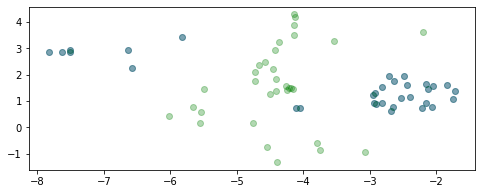

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 2113.8931


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


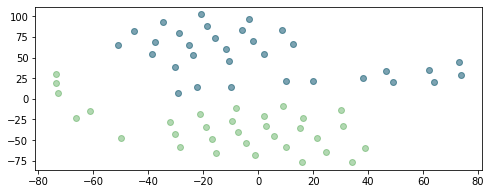

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 108.6436


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


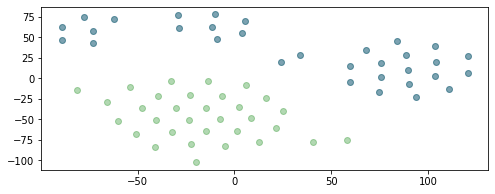

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 94.9722


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


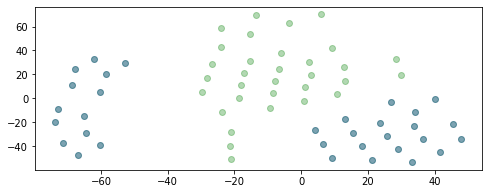

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 59.1816


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


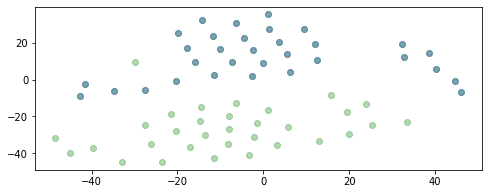

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 42.4684


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


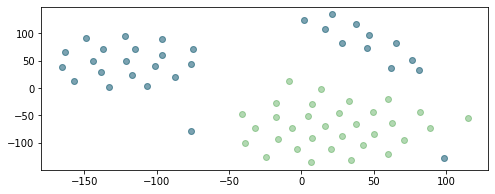

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 42.0425


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


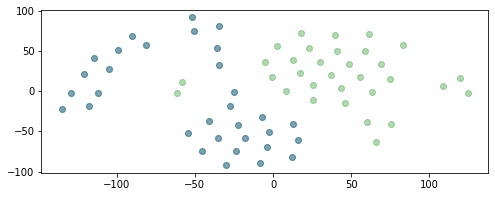

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 39.0387


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


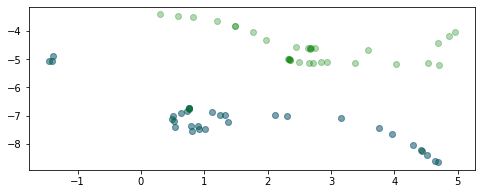

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 37.4983


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


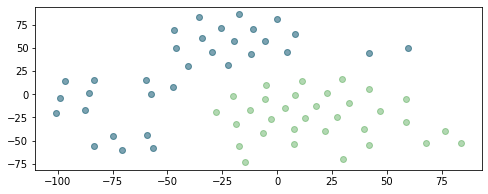

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 36.4501


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


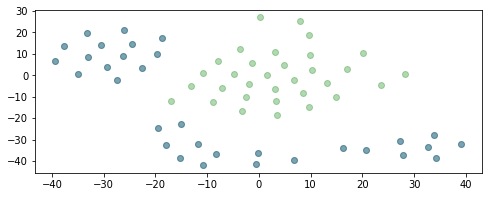

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 36.9543


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


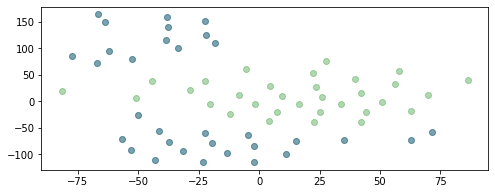

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 36.1928


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


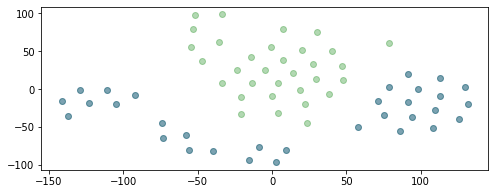

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 35.2271


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


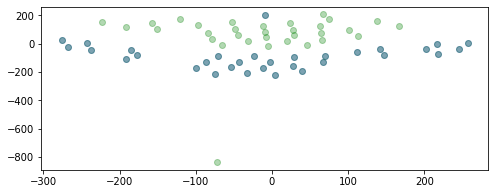

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 35.3474


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


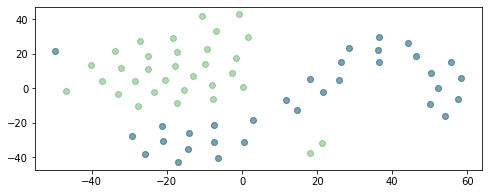

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 35.2380


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


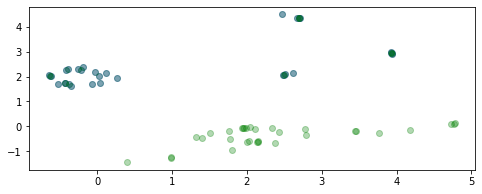

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 34.7674


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


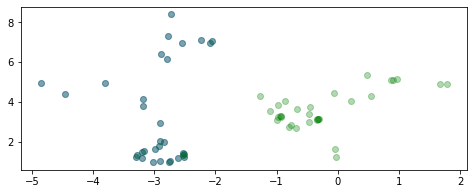

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 34.3366


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


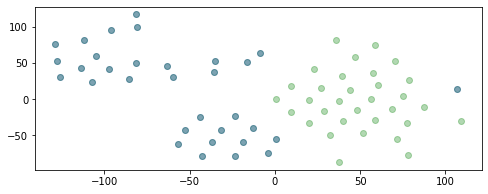

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 34.2218


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


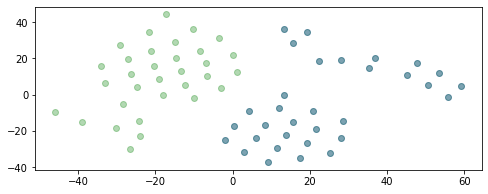

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.5690


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


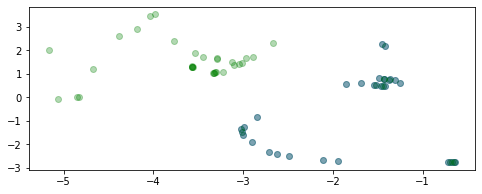

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 35.9204


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


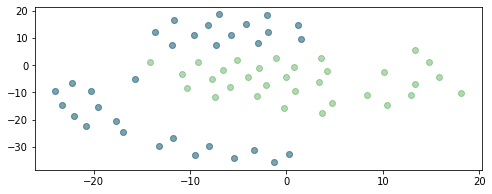

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.6338


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


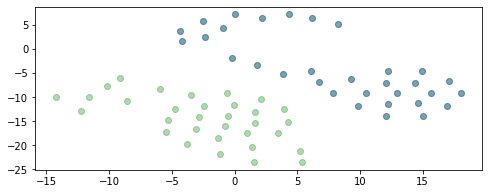

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.5595


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


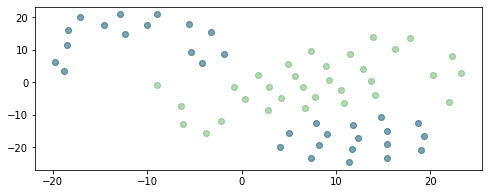

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 40.0009


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


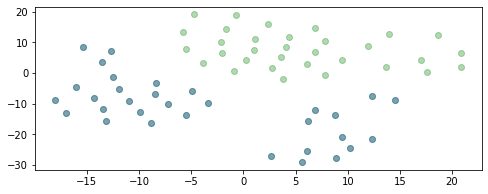

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.3896


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


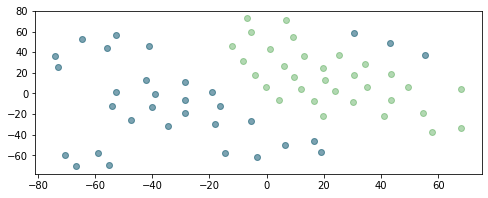

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.6282


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


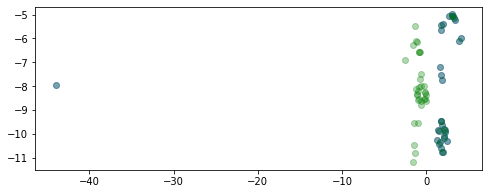

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.9227


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


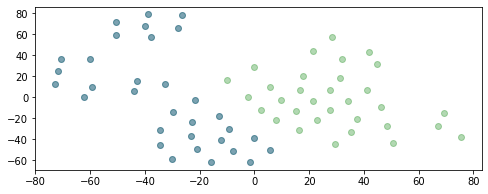

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 32.9964


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


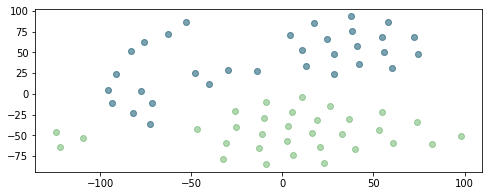

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.3640


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


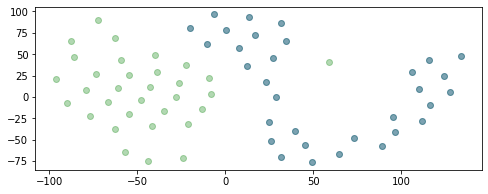

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 33.2016


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


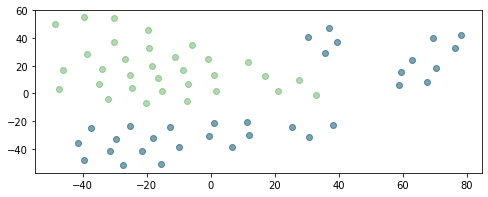

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 80.4323


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


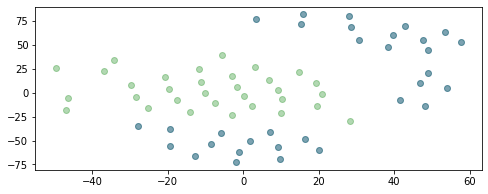

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 38.2635


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


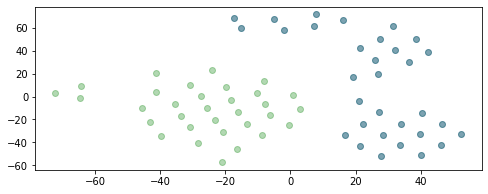

<Figure size 864x360 with 0 Axes>

Epoch [1/2], TestLoss: 34.2253
Epoch [1/2], TestLoss: 37.2312


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


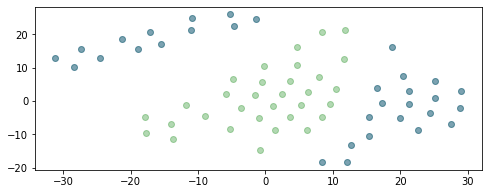

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 33.1444


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


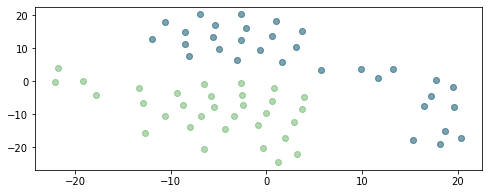

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 33.5706


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


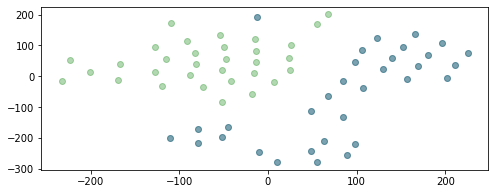

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 32.6678


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


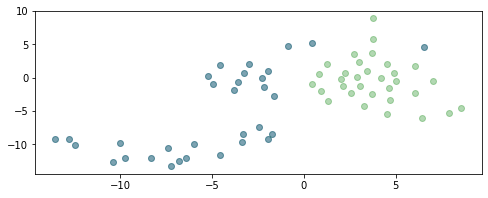

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 33.2079


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


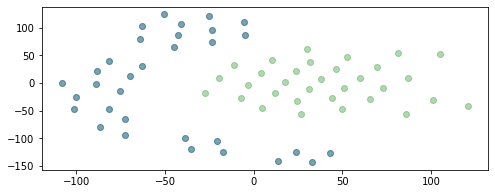

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 32.6320


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


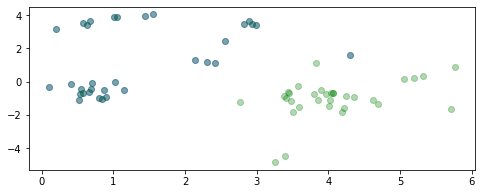

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 32.7001


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


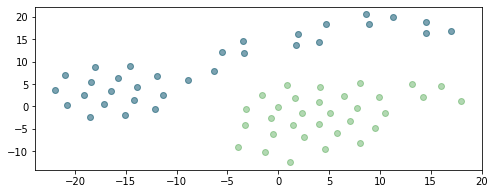

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 33.3594


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


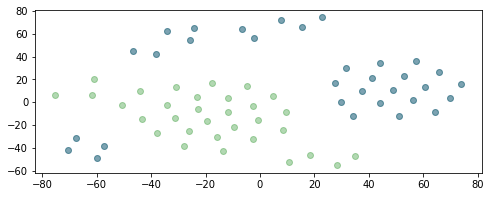

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 32.7502


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


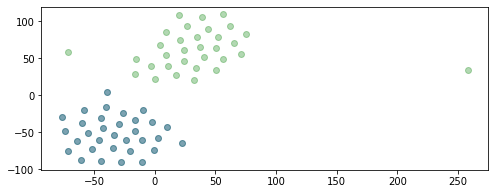

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 2668.5015


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


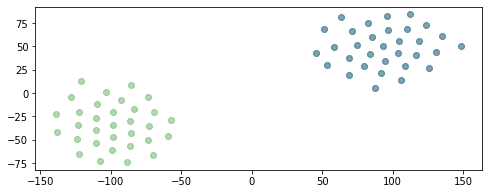

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 113.9738


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


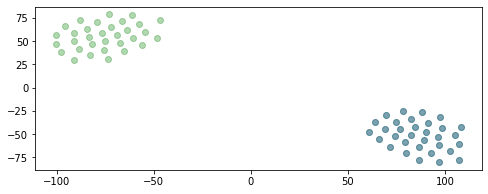

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.7729


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


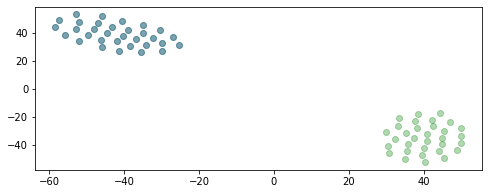

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.3901


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


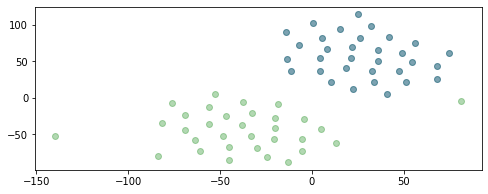

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.3546


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


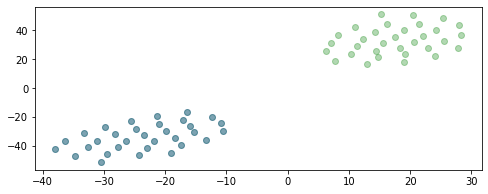

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.2643


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


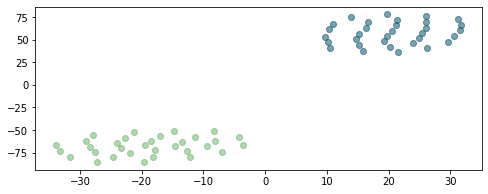

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.8836


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


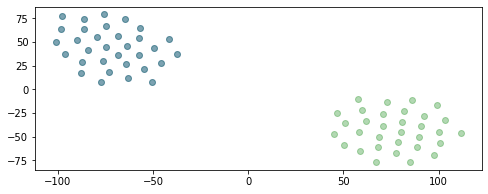

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.1190


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


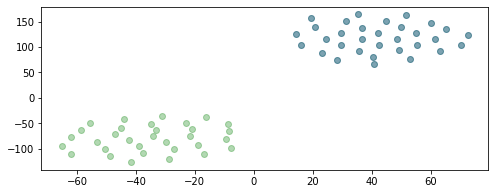

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.2136


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


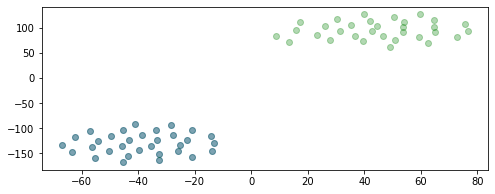

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 38.7984


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


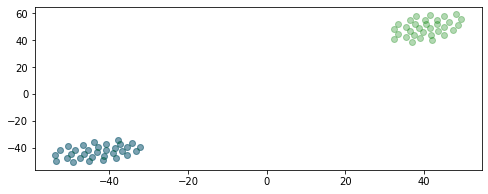

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 40.1158


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


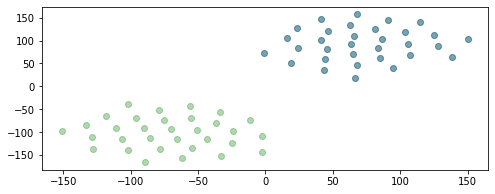

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.2347


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


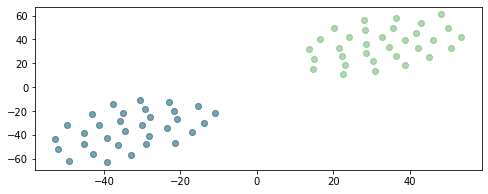

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 39.1843


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


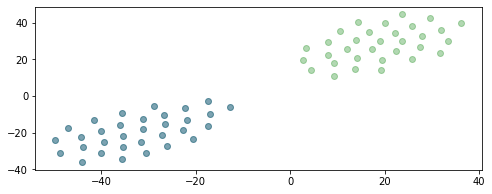

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 38.4382


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


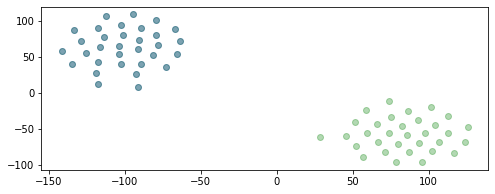

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 40.5056


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


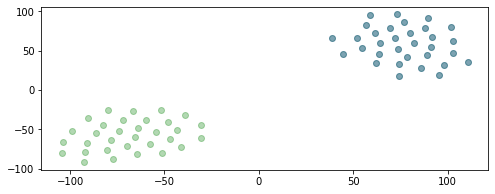

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 40.3025


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


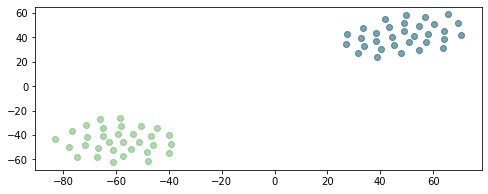

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 38.1545


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


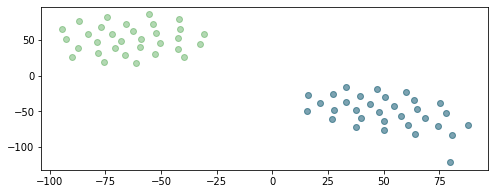

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 40.2661


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


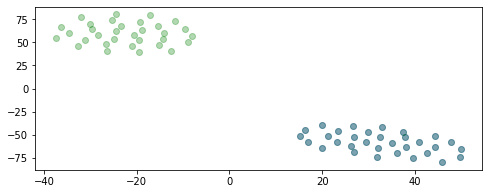

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 59.0331


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


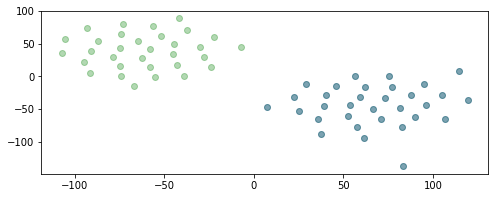

<Figure size 864x360 with 0 Axes>

Epoch [2/2], TestLoss: 38.5382


KeyboardInterrupt: ignored

In [ ]:
# Training the model
lamb = 5e-3
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to('cuda')
            y=y.to('cuda')
            # pred = model(X)
            # test_loss += loss_fn(pred, y).item()

            embedx_test,embedy_test,outputs_test = model(X)
            test_diag = torch.diagonal(outputs_test)
            test_invariance_loss = ((torch.ones_like(test_diag,device="cuda") - test_diag) ** 2).sum()

        #Zero out the diag elements and flatten the matrix to compute the loss
            outputs_test.fill_diagonal_(0)
            test_redundancy_loss = (outputs_test.flatten() ** 2 ).sum()
            loss = test_invariance_loss + lamb * test_redundancy_loss
            #print(" invariance_loss ",test_invariance_loss," redundancy_loss ",test_redundancy_loss)
            test_loss += loss.item()

        test_loss/=num_batches
            
    return test_loss

# TSNE plots after every test set
def plot_tsne(embedx,embedy):
  dim_reducer = TSNE(n_components=2)
  merged = torch.cat((embedx, embedy), dim=0)
  merged = merged.cpu().detach().numpy()

  dim_reducer = dim_reducer.fit_transform(merged)

  pre = dim_reducer[:32]
  tuned = dim_reducer[32:]

  c_size = 36

  x = []
  y = []
  for value in pre:
    x.append([value[0]])
    y.append([value[1]])
      
  f = plt.figure(figsize=(8,3))
  ax = f.add_subplot(111)

  # labels = [str(x) for x in range(10)]

  ax.scatter(x,y, alpha=0.3,color='blue',label='before')


  for value in tuned:
    x.append([value[0]])
    y.append([value[1]])

  # labels = [str(x) for x in range(10)]

  ax.scatter(x,y, alpha=0.3,color='green',label='before')

  plt.figure(figsize=(12, 5))
  plt.show()



n_total_steps = len(train_loader)
num_epochs = 2
for epoch in range(num_epochs):
   
    correct=0
    total=0
    for i, (images, labels) in enumerate(train_loader):
      
        images = images.to('cuda')
        labels = labels.to('cuda')

        
        embedx,embedy,outputs = model(images)
        
        diag = torch.diagonal(outputs)
      
        invariance_loss = ((torch.ones_like(diag,device="cuda") - diag) ** 2).sum()

        #Zero out the diag elements and flatten the matrix to compute the loss
        outputs.fill_diagonal_(0)
        redundancy_loss = (outputs.flatten() ** 2 ).sum()
        loss = invariance_loss + lamb * redundancy_loss
        #print(" invariance_loss ",invariance_loss," redundancy_loss ",redundancy_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) == 0:
          plot_tsne(embedx,embedy)
        if (i+1) % 100 == 0:
          plot_tsne(embedx,embedy)
    
        #_, predicted = outputs.max(1)
        #total += labels.size(0)
        #correct += predicted.eq(labels).sum().item()
      

        # if (i+1) % 100 == 0:
        #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        if (i+1) % 100 == 0:
          test_loss=test_loop(test_loader,model)
          print(f'Epoch [{epoch+1}/{num_epochs}], TestLoss: {test_loss:.4f}')
      
    
    #accu= 100 * correct / len(train_data)
    test_loss=test_loop(test_loader,model)
    print(f'Epoch [{epoch+1}/{num_epochs}], TestLoss: {test_loss:.4f}')

In [ ]:
# Saving the weights which would be needed for freezing and stacking linear layer.
torch.save(model.state_dict(), './barlow_model.pt')

In [ ]:
# Loading the stored weights
# model.load_state_dict(torch.load("/content/drive/MyDrive/barlow_model.pt"))

<All keys matched successfully>

In [ ]:
# Freezing the weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
#loading the data
train_data=datasets.STL10(root="./data",split='train',download=True,transform=ToTensor())
test_data=datasets.STL10(root="./data",split='test',download=True,transform=ToTensor())
train_loader=DataLoader(train_data,shuffle=True,batch_size=32)
test_loader=DataLoader(test_data,shuffle=True,batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Creating the stacked model

class BarlowTwins_classification(nn.Module):
  def __init__(self):
    super(BarlowTwins_classification,self).__init__()
    self.linear = nn.Linear(8192,10)

  def forward(self,image):
    # print(image.shape)

    x,y,output = model(image)
    # print("Shape of output is ")
    # print(output.shape)

    #output = output.flatten()
    output = self.linear(output)

    return output

In [ ]:
# Initializing the model
model_classification=BarlowTwins_classification().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_classification.linear.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=2e-4, eps=1e-08, amsgrad=False)

In [ ]:
model_classification.linear.requires_grad = True
loss_fn=nn.CrossEntropyLoss()

In [ ]:
# Training the model
def test_loop(dataloader, model_classification):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model_classification.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to('cuda')
            y=y.to('cuda')
            pred = model_classification(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    Accuracy=100*correct
    return Accuracy

n_total_steps = len(train_loader)
num_epochs = 50
for epoch in range(num_epochs):
   
    correct=0
    total=0
    for i, (images, labels) in enumerate(train_loader):
      
        images = images.to('cuda')
        labels = labels.to('cuda')  


        outputs = model_classification(images)
        loss = loss_fn(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      

        if (i+1) % 20 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      
    
    accu= 100 * correct / len(train_data)
    test_accu=test_loop(test_loader,model_classification)
    print(f'Epoch [{epoch+1}/{num_epochs}], train_accuracy: {accu:.4f},test_accuracy: {test_accu:.4f} %')

# Part 3 - Training using pseudo labelling

## Default run of 1:10

In [ ]:
#loading the data
train_data= datasets.STL10(root="./data",split='train',download=True,transform=ToTensor())
train_unlabeled = datasets.STL10(root="./data",split='unlabeled',download=True,transform=ToTensor())
test_data= datasets.STL10(root="./data",split='test',download=True,transform=ToTensor())
train_loader= DataLoader(train_data,shuffle=True,batch_size=32)
test_loader= DataLoader(test_data,shuffle=True,batch_size=32)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Sample of unlabeled data
unlabeled_subset_size = 100000
train_unlabeled = train_unlabeled.data[:unlabeled_subset_size]
train_unlabeled_loader= DataLoader(train_unlabeled,shuffle=True,batch_size=32)

In [ ]:
# Generating labels with saved model, storing only those images where confidence score is more than 0.99
def generate_labels(unlabelled_loader,threshold):
  x=0
  count=0
  plabels=[]
  image=[]
  with torch.no_grad():
    for i,images in enumerate(tqdm(unlabelled_loader)):
      # print(type(images))
      # print(images)
      images = images.float()
      images=images.to('cuda')
      

      outputs=model(images)
      outputs=F.softmax(outputs,dim=1)
      if((outputs.max()>threshold) ):
        predicted=outputs.max(1)[1]
        plabels.append(predicted)
        image.append(images)
      else:
        count+=1
      
    return plabels,image

pl,imgs=generate_labels(train_unlabeled_loader,0.99)
print(len(imgs))

100%|██████████| 3125/3125 [01:26<00:00, 36.16it/s]

3125


In [ ]:
dataTensor = torch.cat(pl)
print(dataTensor)
dataTensor.to('cuda')
imgTensor=torch.cat(imgs)
print(len(imgTensor))
imgTensor.to('cuda')
i=[imgTensor]
p=[dataTensor]

tensor([9, 2, 9,  ..., 1, 2, 6], device='cuda:0')
32000


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = i[0]
        self.targets = p[0]
       
        
    def __getitem__(self, index):
        x = self.data[index]
        y=self.targets[index]
        return x,y
    
    def __len__(self):
        return len(self.data)



transform = transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
dataset = MyDataset(i,p)
print(dataset[0][0].shape)

In [ ]:
x=[]
y=[]
for i,(images,labels) in enumerate(train_loader):
  images=images.to("cuda")
  labels=labels.to("cuda")
  x.append(images)
  y.append(labels)

In [ ]:
train_x=torch.cat(x)
train_y=torch.cat(y)
type(train_y)

torch.Tensor

In [ ]:
class tDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = train_x
        self.targets = train_y
        print(len(self.data))
        
        self.transform = transform
        
    def __getitem__(self, i):
        x = self.data[i]
        y=self.targets[i]
        return x,y
    
    def __len__(self):
        return len(self.data)
data = tDataset(train_x,train_y)
len(data)

5000


5000

In [ ]:
concatDataset=torch.utils.data.ConcatDataset([dataset,data])
loader = DataLoader(concatDataset, batch_size=32,shuffle=True)
len(concatDataset)

5001

In [ ]:
model=ResNet().to("cuda")

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=2e-4, eps=1e-08, amsgrad=False)

In [ ]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    total=0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to('cuda')
            y=y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _, predicted = pred.max(1)
            #print(predicted,y)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    Accuracy=100*correct
    return Accuracy

In [ ]:
num_epochs1=10
threshold=0.999

n_total_steps = len(loader)
for epoch in range(1):
   
    correct=0
    total=0
    for i, (images, labels) in enumerate(loader):
      
    
        images = images.to("cuda")
        labels = labels.to("cuda",dtype=torch.int64)
      

        
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs1}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      
    
    accu= 100 * correct / len(concatDataset)
    test_accu=test_loop(test_loader,model)
    print(f'Epoch [{epoch+1}/{num_epochs1}], test_accuracy: {accu:.4f} %')

# Bonus -  With different %age of Labeled and Unlabeled

## Default run of 1:0.4

In [ ]:
#loading the data
train_data= datasets.STL10(root="./data",split='train',download=True,transform=ToTensor())
train_unlabeled = datasets.STL10(root="./data",split='unlabeled',download=True,transform=ToTensor())
test_data= datasets.STL10(root="./data",split='test',download=True,transform=ToTensor())
train_loader= DataLoader(train_data,shuffle=True,batch_size=32)
test_loader= DataLoader(test_data,shuffle=True,batch_size=32)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
unlabeled_subset_size = 2000
train_unlabeled = train_unlabeled.data[:unlabeled_subset_size]
train_unlabeled_loader= DataLoader(train_unlabeled,shuffle=True,batch_size=32)

In [ ]:
def generate_labels(unlabelled_loader,threshold):
  x=0
  count=0
  plabels=[]
  image=[]
  with torch.no_grad():
    for i,images in enumerate(tqdm(unlabelled_loader)):
      # print(type(images))
      # print(images)
      images = images.float()
      images=images.to('cuda')
      

      outputs=model(images)
      outputs=F.softmax(outputs,dim=1)
      if((outputs.max()>threshold) ):
        predicted=outputs.max(1)[1]
        plabels.append(predicted)
        image.append(images)
      else:
        count+=1
      
    return plabels,image

pl,imgs=generate_labels(train_unlabeled_loader,0.99)
print(len(imgs))

In [ ]:
dataTensor = torch.cat(pl)
print(dataTensor)
dataTensor.to('cuda')
imgTensor=torch.cat(imgs)
print(len(imgTensor))
imgTensor.to('cuda')
i=[imgTensor]
p=[dataTensor]

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = i[0]
        self.targets = p[0]
       
        
    def __getitem__(self, index):
        x = self.data[index]
        y=self.targets[index]
        return x,y
    
    def __len__(self):
        return len(self.data)



transform = transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
dataset = MyDataset(i,p)
print(dataset[0][0].shape)

In [ ]:
x=[]
y=[]
for i,(images,labels) in enumerate(train_loader):
  images=images.to("cuda")
  labels=labels.to("cuda")
  x.append(images)
  y.append(labels)

In [ ]:
train_x=torch.cat(x)
train_y=torch.cat(y)
type(train_y)

torch.Tensor

In [ ]:
class tDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = train_x
        self.targets = train_y
        print(len(self.data))
        
        self.transform = transform
        
    def __getitem__(self, i):
        x = self.data[i]
        y=self.targets[i]
        return x,y
    
    def __len__(self):
        return len(self.data)
data = tDataset(train_x,train_y)
len(data)

5000


5000

In [ ]:
concatDataset=torch.utils.data.ConcatDataset([dataset,data])
loader = DataLoader(concatDataset, batch_size=32,shuffle=True)
len(concatDataset)

In [ ]:
model=ResNet().to("cuda")

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=2e-4, eps=1e-08, amsgrad=False)

In [ ]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    total=0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to('cuda')
            y=y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _, predicted = pred.max(1)
            #print(predicted,y)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    Accuracy=100*correct
    return Accuracy

In [ ]:
num_epochs1=10
threshold=0.999

n_total_steps = len(loader)
for epoch in range(num_epochs1):
   
    correct=0
    total=0
    for i, (images, labels) in enumerate(loader):
      
    
        images = images.to("cuda")
        labels = labels.to("cuda",dtype=torch.int64)
      

        
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs1}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      
    
    accu= 100 * correct / len(concatDataset)
    test_accu=test_loop(test_loader,model)
    print(f'Epoch [{epoch+1}/{num_epochs1}], test_accuracy: {accu:.4f} %')

## Default run of 1:1

In [ ]:
#loading the data
train_data= datasets.STL10(root="./data",split='train',download=True,transform=ToTensor())
train_unlabeled = datasets.STL10(root="./data",split='unlabeled',download=True,transform=ToTensor())
test_data= datasets.STL10(root="./data",split='test',download=True,transform=ToTensor())
train_loader= DataLoader(train_data,shuffle=True,batch_size=32)
test_loader= DataLoader(test_data,shuffle=True,batch_size=32)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
unlabeled_subset_size = 5000
train_unlabeled = train_unlabeled.data[:unlabeled_subset_size]
train_unlabeled_loader= DataLoader(train_unlabeled,shuffle=True,batch_size=32)

In [ ]:
def generate_labels(unlabelled_loader,threshold):
  x=0
  count=0
  plabels=[]
  image=[]
  with torch.no_grad():
    for i,images in enumerate(tqdm(unlabelled_loader)):
      # print(type(images))
      # print(images)
      images = images.float()
      images=images.to('cuda')
      

      outputs=model(images)
      outputs=F.softmax(outputs,dim=1)
      if((outputs.max()>threshold) ):
        predicted=outputs.max(1)[1]
        plabels.append(predicted)
        image.append(images)
      else:
        count+=1
      
    return plabels,image

pl,imgs=generate_labels(train_unlabeled_loader,0.99)
print(len(imgs))

In [ ]:
dataTensor = torch.cat(pl)
print(dataTensor)
dataTensor.to('cuda')
imgTensor=torch.cat(imgs)
print(len(imgTensor))
imgTensor.to('cuda')
i=[imgTensor]
p=[dataTensor]

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = i[0]
        self.targets = p[0]
       
        
    def __getitem__(self, index):
        x = self.data[index]
        y=self.targets[index]
        return x,y
    
    def __len__(self):
        return len(self.data)



transform = transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
dataset = MyDataset(i,p)
print(dataset[0][0].shape)

In [ ]:
x=[]
y=[]
for i,(images,labels) in enumerate(train_loader):
  images=images.to("cuda")
  labels=labels.to("cuda")
  x.append(images)
  y.append(labels)

In [ ]:
train_x=torch.cat(x)
train_y=torch.cat(y)
type(train_y)

torch.Tensor

In [ ]:
class tDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = train_x
        self.targets = train_y
        print(len(self.data))
        
        self.transform = transform
        
    def __getitem__(self, i):
        x = self.data[i]
        y=self.targets[i]
        return x,y
    
    def __len__(self):
        return len(self.data)
data = tDataset(train_x,train_y)
len(data)

5000


5000

In [ ]:
concatDataset=torch.utils.data.ConcatDataset([dataset,data])
loader = DataLoader(concatDataset, batch_size=32,shuffle=True)
len(concatDataset)

In [ ]:
model=ResNet().to("cuda")

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=2e-4, eps=1e-08, amsgrad=False)

In [ ]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    total=0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to('cuda')
            y=y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _, predicted = pred.max(1)
            #print(predicted,y)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    Accuracy=100*correct
    return Accuracy

In [ ]:
num_epochs1=10
threshold=0.999

n_total_steps = len(loader)
for epoch in range(num_epochs1):
   
    correct=0
    total=0
    for i, (images, labels) in enumerate(loader):
      
    
        images = images.to("cuda")
        labels = labels.to("cuda",dtype=torch.int64)
      

        
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs1}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      
    
    accu= 100 * correct / len(concatDataset)
    test_accu=test_loop(test_loader,model)
    print(f'Epoch [{epoch+1}/{num_epochs1}], test_accuracy: {accu:.4f} %')

## Default run of 1:2

In [ ]:
#loading the data
train_data= datasets.STL10(root="./data",split='train',download=True,transform=ToTensor())
train_unlabeled = datasets.STL10(root="./data",split='unlabeled',download=True,transform=ToTensor())
test_data= datasets.STL10(root="./data",split='test',download=True,transform=ToTensor())
train_loader= DataLoader(train_data,shuffle=True,batch_size=32)
test_loader= DataLoader(test_data,shuffle=True,batch_size=32)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
unlabeled_subset_size = 10000
train_unlabeled = train_unlabeled.data[:unlabeled_subset_size]
train_unlabeled_loader= DataLoader(train_unlabeled,shuffle=True,batch_size=32)

In [ ]:
def generate_labels(unlabelled_loader,threshold):
  x=0
  count=0
  plabels=[]
  image=[]
  with torch.no_grad():
    for i,images in enumerate(tqdm(unlabelled_loader)):
      # print(type(images))
      # print(images)
      images = images.float()
      images=images.to('cuda')
      

      outputs=model(images)
      outputs=F.softmax(outputs,dim=1)
      if((outputs.max()>threshold) ):
        predicted=outputs.max(1)[1]
        plabels.append(predicted)
        image.append(images)
      else:
        count+=1
      
    return plabels,image

pl,imgs=generate_labels(train_unlabeled_loader,0.99)
print(len(imgs))

In [ ]:
dataTensor = torch.cat(pl)
print(dataTensor)
dataTensor.to('cuda')
imgTensor=torch.cat(imgs)
print(len(imgTensor))
imgTensor.to('cuda')
i=[imgTensor]
p=[dataTensor]

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = i[0]
        self.targets = p[0]
       
        
    def __getitem__(self, index):
        x = self.data[index]
        y=self.targets[index]
        return x,y
    
    def __len__(self):
        return len(self.data)



transform = transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
dataset = MyDataset(i,p)
print(dataset[0][0].shape)

In [ ]:
x=[]
y=[]
for i,(images,labels) in enumerate(train_loader):
  images=images.to("cuda")
  labels=labels.to("cuda")
  x.append(images)
  y.append(labels)

In [ ]:
train_x=torch.cat(x)
train_y=torch.cat(y)
type(train_y)

torch.Tensor

In [ ]:
class tDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = train_x
        self.targets = train_y
        print(len(self.data))
        
        self.transform = transform
        
    def __getitem__(self, i):
        x = self.data[i]
        y=self.targets[i]
        return x,y
    
    def __len__(self):
        return len(self.data)
data = tDataset(train_x,train_y)
len(data)

5000


5000

In [ ]:
concatDataset=torch.utils.data.ConcatDataset([dataset,data])
loader = DataLoader(concatDataset, batch_size=32,shuffle=True)
len(concatDataset)

In [ ]:
model=ResNet().to("cuda")

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=2e-4, eps=1e-08, amsgrad=False)

In [ ]:
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    total=0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to('cuda')
            y=y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _, predicted = pred.max(1)
            #print(predicted,y)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    Accuracy=100*correct
    return Accuracy

In [ ]:
num_epochs1=10
threshold=0.999

n_total_steps = len(loader)
for epoch in range(num_epochs1):
   
    correct=0
    total=0
    for i, (images, labels) in enumerate(loader):
      
    
        images = images.to("cuda")
        labels = labels.to("cuda",dtype=torch.int64)
      

        
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs1}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      
    
    accu= 100 * correct / len(concatDataset)
    test_accu=test_loop(test_loader,model)
    print(f'Epoch [{epoch+1}/{num_epochs1}], test_accuracy: {accu:.4f} %')

Results to these run and averaged out are reported in the report doc created